In [35]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    'Num cells x1': load_data('../stats/fpm_4_x1.json'),
# #     # 'num cells x64': load_data('../stats/fpm_3_x4.json'),
    'Num cells x8': load_data('../stats/fpm_4_x2.json'),
# #     # 'num cells x125': load_data('../stats/fpm_3_x5.json'),
    # 'Num cells x27': load_data('../stats/fpm_4_x3.json'),
# #     # 'num cells x216': load_data('../stats/fpm_3_x6.json'),
}

In [36]:
shape = [3, 1]
figsize = (7, 5)

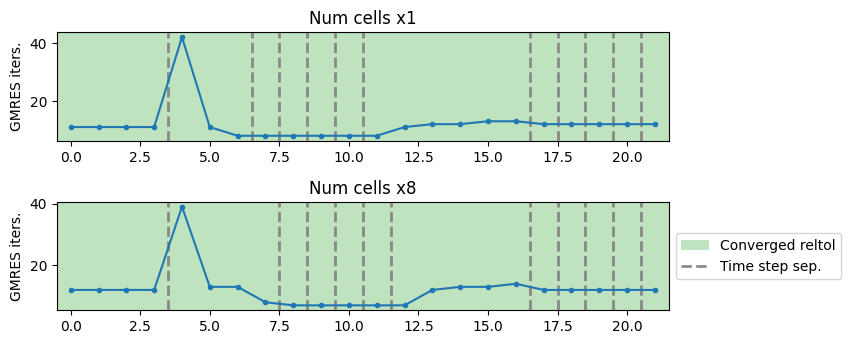

In [37]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

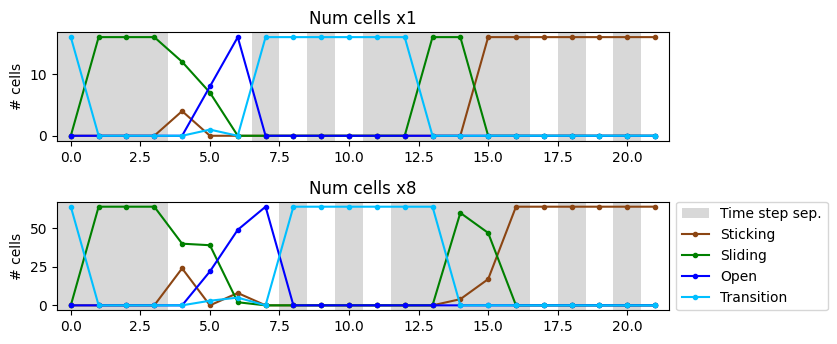

In [38]:
def render_element(entry: Sequence[TimeStepStats]):
    st, sl, op, tr = get_num_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.plot(st, label='Sticking', marker='.', color=COLOR_STICKING)
    plt.plot(sl, label='Sliding', marker='.', color=COLOR_SLIDING)
    plt.plot(op, label='Open', marker='.', color=COLOR_OPEN)
    plt.plot(tr, label='Transition', marker='.', color=COLOR_TRANSITION)

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# cells')

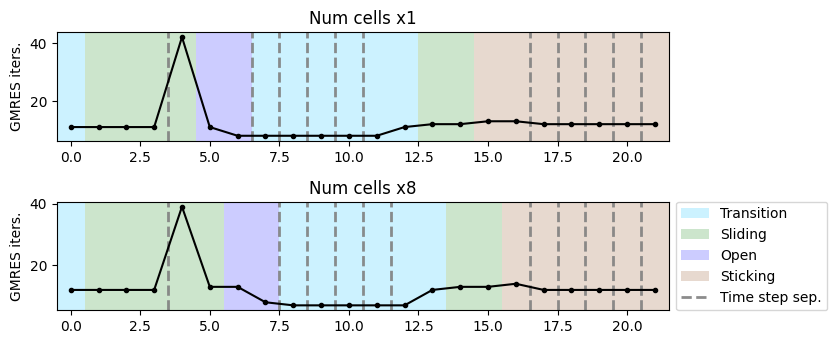

In [39]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')
    # plt.ylim(top=21)

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

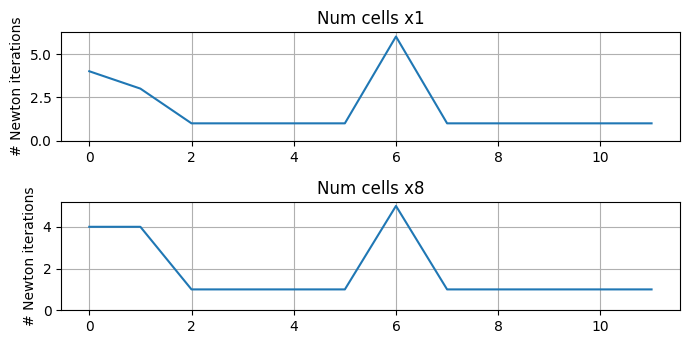

In [40]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step', legend=False)

# Testing bad matrix

In [41]:
assert False

AssertionError: 

In [42]:
from fpm_4 import make_model

model = make_model()
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()


num sticking: 0
num sliding: 0
num open: 0
num trans: 64


In [185]:
mat_idx = 4
entry = data['Num cells x8']
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

39


In [186]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1

model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

model.assemble_linear_system()
perm_mat, prec_orig = model._prepare_solver()
J = perm_mat[:]

24
40
0
0


Solve  took: 2.24
True residual decrease: 0.009308132581617877


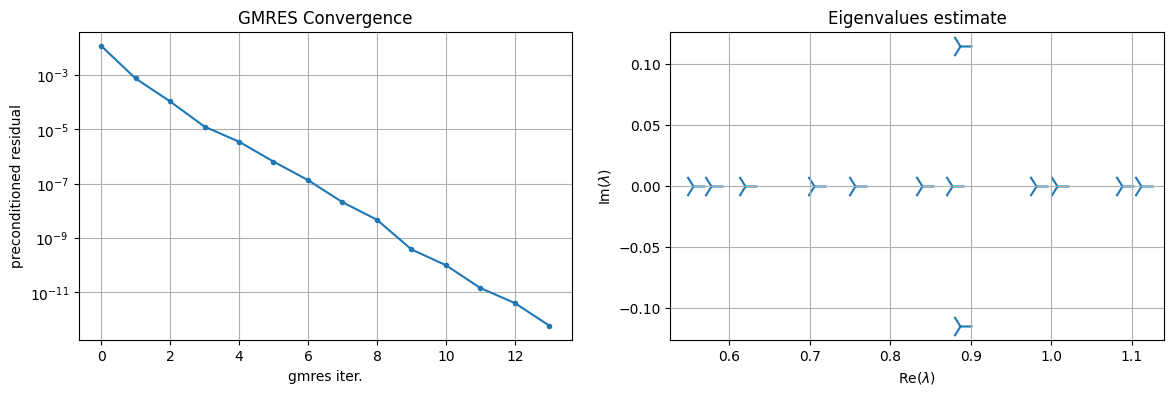

In [187]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

Solve  took: 1.09
True residual decrease: 2.0485009008184526e-06


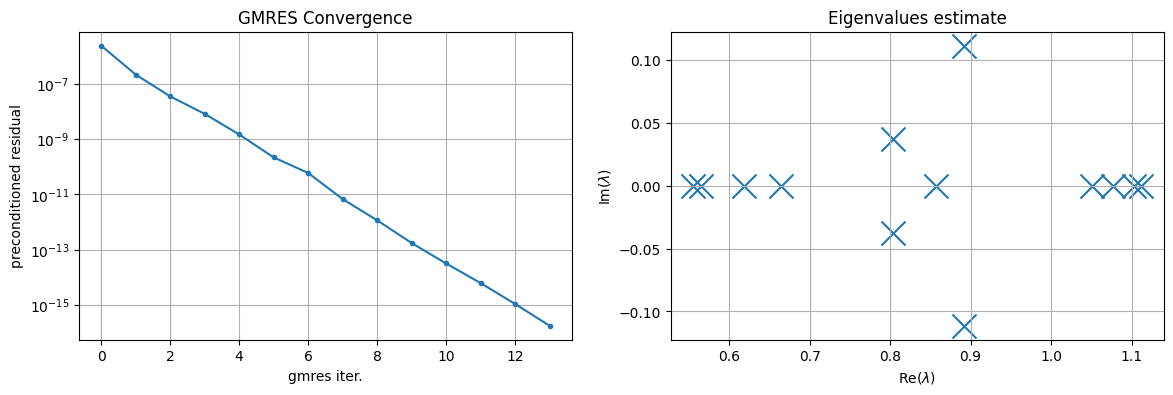

In [188]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_fs

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv_bdiag(model, bmat=bmat),
    complement=SolveSchema(
        # groups=[3],
        # solve=lambda bmat: PetscILU(bmat[[3]].mat),
        # invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            # invertor=lambda bmat: make_fs(model, bmat).mat,
            # invertor=lambda bmat: model._fixed_stress.mat,
            # invertor_type="physical",
            # complement=SolveSchema(
            #     groups=[0, 2],
            #     solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            # ),
        # ),
    ),
)

bmat_reordered, preconditioner = make_solver(schema=schema, mat_orig=J)
solve_petsc(bmat_reordered.mat, preconditioner, rhs=bmat_reordered.local_rhs(rhs))

In [189]:
bmat = J
J44 = bmat[4,4].mat
J55 = bmat[5,5].mat
# J55_inv = inv_block_diag(J55, nd=model.nd)
J55_inv = inv(J55)
stab = bmat[4, 5].mat @ J55_inv @ bmat[5, 4].mat
st, sl, op, tr = model.sticking_sliding_open_transition()

sliding_tang = np.repeat(sl, model.nd)
sliding_tang[::model.nd] = 0  # we need only tangential
stab[sliding_tang] = 0

sliding_norm = np.repeat(sl, model.nd)
sliding_norm[1::model.nd] = 0
sliding_norm[2::model.nd] = 0

# stab[sliding_norm, 0::3] = 0
# stab[sliding_norm, 1::3] = 0

S44 = J44 - stab

sticking = np.repeat(st, model.nd)
S44[sticking] *= 0.5
S44[sliding_norm] *= 0.5

j45_modified = bmat[4, 5].mat
j45_modified[sticking] *= 0.5
j45_modified[sliding_norm] *= 0.5

In [190]:
J45 = J[[4, 5]].copy().mat
J45_stab = J[[4, 5]].copy()
J45_stab[4, 4] = S44

J45_stab[4, 5] = j45_modified

cond(inv(J45_stab.mat) @ J45)

2647.350782257454

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


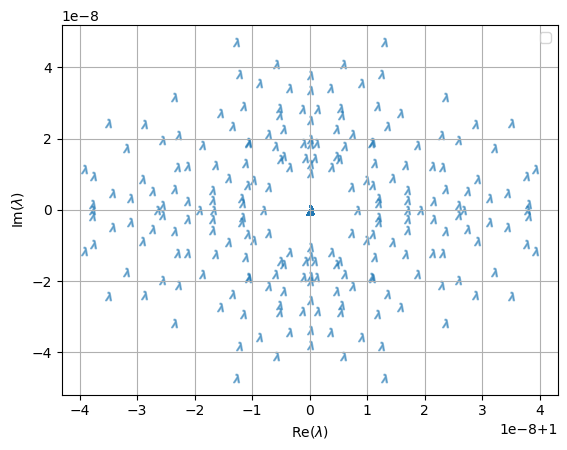

In [191]:
plot_eigs(inv(J45_stab.mat) @ J45)

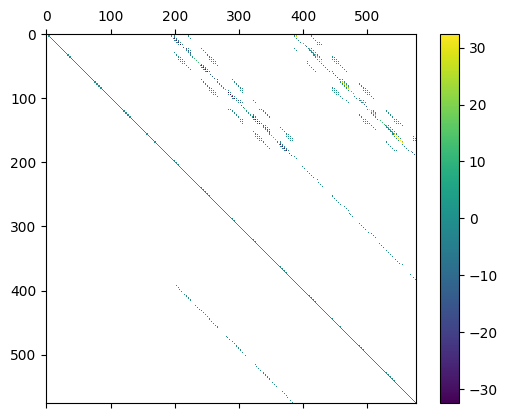

In [192]:
%matplotlib inline
plot_mat(inv(J45_stab.mat) @ J45, log=False, threshold=1e-1)

In [193]:
np.where(st)

(array([ 5,  6,  7, 13, 14, 15, 21, 22, 23, 29, 30, 31, 37, 38, 39, 45, 46,
        47, 53, 54, 55, 61, 62, 63]),)

In [194]:
approx_I = inv(J45_stab.mat) @ J45
approx_I.diagonal()

array([0.93809857, 0.99993725, 0.56196418, 0.93640357, 0.9999723 ,
       0.56362413, 0.93491381, 0.99998248, 0.5651037 , 0.93416489,
       0.99999087, 0.56584424, 0.93571437, 0.99999559, 0.56429004,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.93753059,
       0.99995126, 0.56251815, 0.93596501, 0.99998057, 0.56405443,
       0.93467752, 0.99998951, 0.56533297, 0.93417169, 0.99999548,
       0.56583283, 0.93591621, 0.9999985 , 0.56408529, 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.937306  , 0.99997977,
       0.56271422, 0.93585359, 0.99999183, 0.56415459, 0.9347052 ,
       0.99999599, 0.56529881, 0.93423281, 0.99999854, 0.56576866,
       0.93577921, 0.99999969, 0.5642211 , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.93719174, 0.99999812, 0.56281